# Regularized Regression: L$_1$ and L$_2$
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/regularization_techniques_l1_l2.ipynb)



Avoiding overfitting with regularization.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
if IN_COLAB:
    !apt-get install libproj-dev proj-data proj-bin
    !apt-get install libgeos-dev
    !pip install cython
    !pip install cartopy
    !apt-get -qq install python-cartopy python3-cartopy
    !pip uninstall -y shapely
    !pip install shapely --no-binary shapely

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.io as io
import copy as copy
import csv
import datetime
import pandas as pd
import xarray as xr
import matplotlib as mpl
import cartopy as ct

# set figure defaults
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 8.0/2)

## Get data

In [3]:
# Load the data

if IN_COLAB:
    !pip install wget
    import wget
    filename = wget.download("https://raw.githubusercontent.com/eabarnes1010/course_objective_analysis/main/data/christman_2016.csv")
else:
    filename = '../data/christman_2016.csv'

data_input = np.genfromtxt(filename, delimiter = ',')

# grab the variables I want
# grab_indices = [2,3,5,9,10,11]
grab_indices = [4,2,5,9,10,11]

data = data_input[:,grab_indices]

names_input = ['date','time','temp (F)', 'RH (%)', 'DewPt (F)','Wind (mph)', 'Dir (deg.)', 'Gust (mph)', 'Gust Dir (deg.)','Pres (mb)', 'Solar (W/m^2)','Precip (in)']
names = [names_input[i] for i in grab_indices]

# convert precip inches to mm
data[:,[i for i, s in enumerate(names) if 'Precip' in s]] = data[:,[i for i, s in enumerate(names) if 'Precip' in s]]*25.4
names[names.index('Precip (in)')] = 'Precip (mm)'

print(np.shape(data))
print(names)

(8784, 6)
['DewPt (F)', 'temp (F)', 'Wind (mph)', 'Pres (mb)', 'Solar (W/m^2)', 'Precip (mm)']


In [4]:
# standardize the data since everything has different units
data_std = preprocessing.scale(data)

print(data_std.mean(axis=0))
print(data_std.std(axis=0))

[ 5.17699625e-17  2.58849813e-16 -6.47124532e-18 -1.65081468e-14
 -8.08905665e-17 -1.45603020e-17]
[1. 1. 1. 1. 1. 1.]


In [5]:
# define the predictors and predictand

# predict Dewpoint
y = data_std[:,0]

# define predictors (all 5 other variables)
x = data_std[:,1:]

## Motivation for regularization

Let's look at example of when regularization may be useful by doing some regression with hourly data from Christmas Field. Specifically, we will fit a line to the data using 5 potentially useful predictors and 45 completely useless ones (based on gaussian white noise). Let's see how the correlation between the true dewpoint and the predicted dewpoint change with the number of predictors.

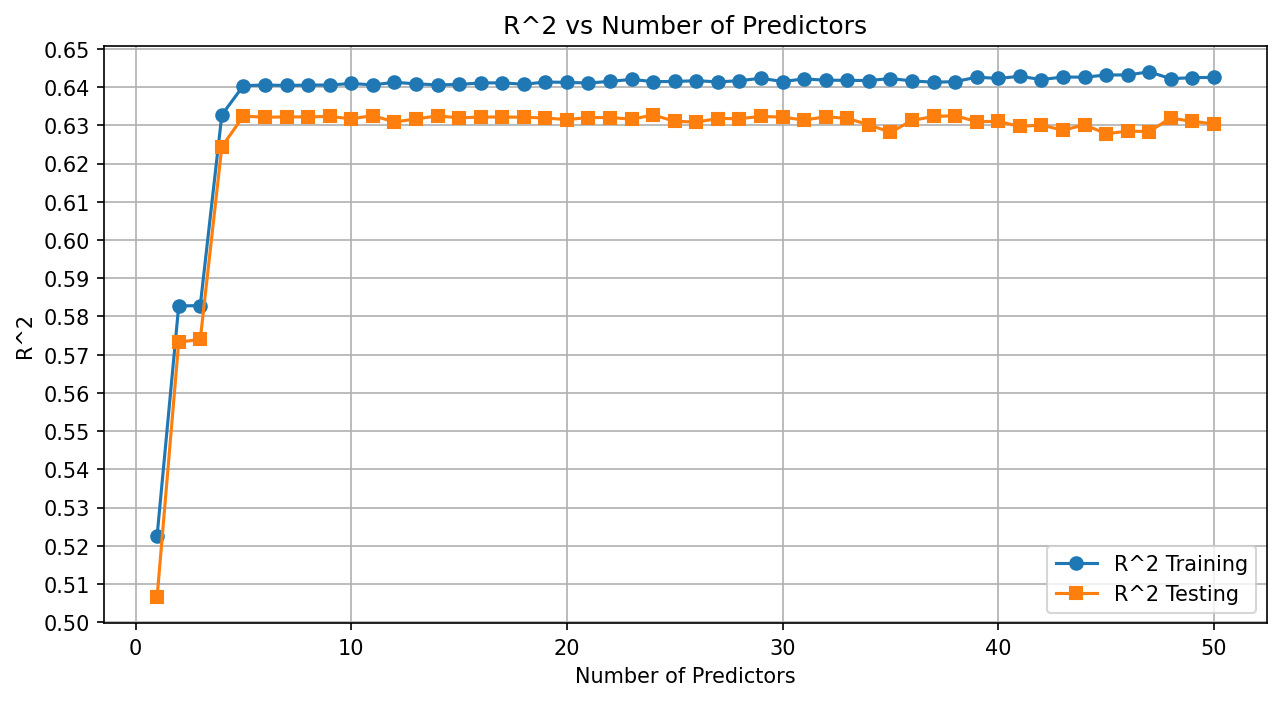

In [6]:
max_p = 50
r2_score = []
r2_testscore = []
for p in range(1,max_p + 1):

    if p <= x.shape[1]:
        X_train, X_test, y_train, y_test = train_test_split(x[:, 0:p], y, test_size=0.3, random_state=42, shuffle=True)
    else:
        x_all = np.append(x, 3*np.random.random(((x.shape[0], p - x.shape[1])))*np.ones((x.shape[0], p - x.shape[1])), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(x_all, y, test_size=0.3, random_state=42, shuffle=True)

    regOLS = linear_model.LinearRegression(fit_intercept=True)
    fit = regOLS.fit(X_train, y_train)
    r2_score.append(np.corrcoef(fit.predict(X_train), y_train)[0,1]**2)
    r2_testscore.append(np.corrcoef(fit.predict(X_test), y_test)[0,1]**2)

plt.figure(figsize=(10, 5))
plt.plot(range(1, max_p+1), r2_score, label='R^2 Training', marker='o')
plt.plot(range(1, max_p+1), r2_testscore, label='R^2 Testing', marker='s')
plt.xlabel('Number of Predictors')
plt.ylabel('R^2')
plt.title('R^2 vs Number of Predictors')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.01))
plt.show()

What do we find? We find that the R^2 value for the _training set_ increases as we add more predictors. This is because we are overfitting the data. The _testing set_ actually shows decreasing R^2 with additional random predictors. This is because what we are learning on the training set is not transferable to out-of-training data.

## Example: when $L_1$ makes sense

$L_1$ regularization (or LASSO) adds a term to the loss function that is proportional to the sum of the absolute value of the regression coefficients:

$\lambda \sum_i^N |\beta_i|$

This term acts to force small coefficients to *exactly* zero, and allowing only a few to stay large. $\lambda$ (or $\alpha$ as it is specified below), sets how important this term is. 

Okay - let's fit the line and look how different forms of regularization impact the solution. Remember that $\lambda$ determines how important the regularization term is when computing the loss function. Make it big, and regularization becomes very important. Make $\lambda=0$ and you are back to standard OLS regression.

*Note that in sklearn they use $\alpha$ instead of $\lambda$.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

print(np.shape(X_train))
print(np.shape(X_test))

(6148, 5)
(2636, 5)


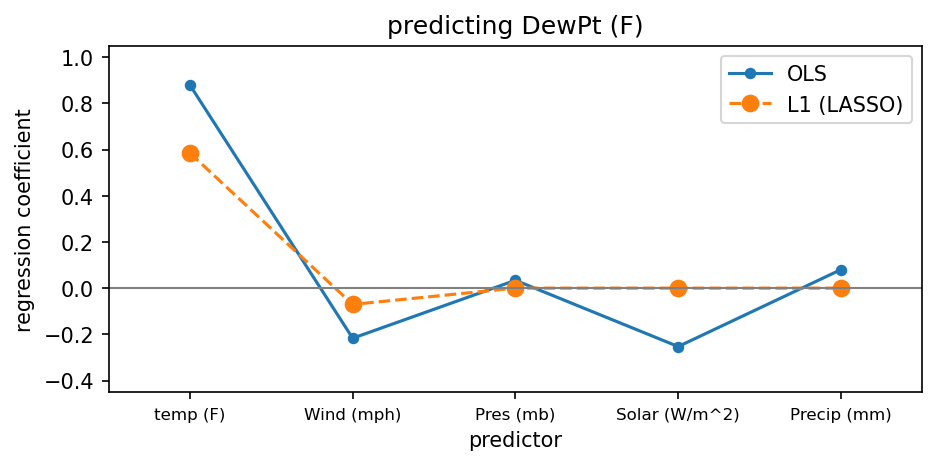

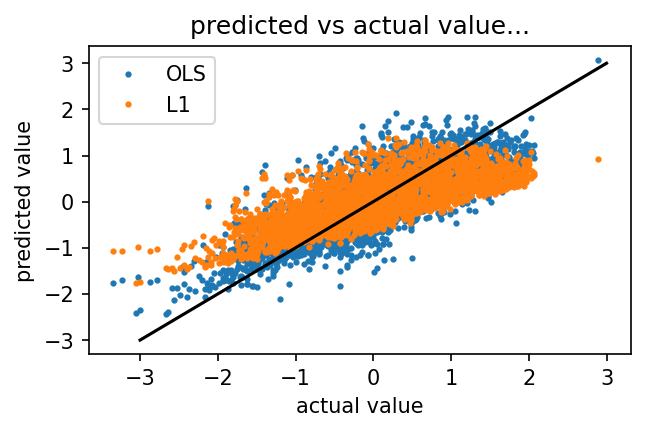

In [8]:
#--------------------------------------
# Regression Fitting
regOLS = linear_model.LinearRegression(fit_intercept=True)
regL1 = linear_model.Lasso(alpha=.15, fit_intercept=True)
regL2 = linear_model.Ridge(alpha=2000, fit_intercept=True)

regOLS.fit(X_train,y_train)
regL1.fit(X_train,y_train)
regL2.fit(X_train,y_train)

predictOLS = regOLS.predict(X_test)
predictL1 = regL1.predict(X_test)
predictL2 = regL2.predict(X_test)
#--------------------------------------

MS = 4

plt.figure(figsize=(7,3))
plt.plot(regOLS.coef_,'.-', markersize=9, label='OLS')
plt.plot(regL1.coef_,'.--', markersize=15, label='L1 (LASSO)')
# plt.plot(regL2.coef_,'.--', markersize=9, label='L2 (Ridge)')
plt.xticks(np.arange(0,5), labels=names[1:], fontsize=8)
plt.xlabel('predictor')
plt.ylabel('regression coefficient')
plt.axhline(y=0,color='gray', linewidth=1)
plt.legend()
plt.xlim(-.5,4.5)
plt.ylim(-.45,1.05)
plt.title('predicting ' + names[0])
plt.show()

plt.figure(figsize=(7/1.5,4/1.5))
plt.title('predicted vs actual value...')
plt.plot(y_test,predictOLS, '.', markersize=MS, label='OLS')
plt.plot(y_test,predictL1, '.', markersize=MS, label='L1')
# plt.plot(y_test,predictL2, '.', markersize=MS, label='L2')
plt.plot((-3,3),(-3,3),'-k')
plt.ylabel('predicted value')
plt.xlabel('actual value')
plt.legend()
plt.show()


Fun! LASSO regularization helps us determine which variables are the *most* important, and helps us to avoid overfitting. It sets small coefficients to zero.

## Example: when Ridge ($L_2$) makes sense

While LASSO helps set small coefficients to zero, Ridge regression (or $L_2$ regularization) helps spread/share the weights across all of the regression coefficients. The term added to the loss function is:

$\lambda \sum_i^N \beta_i^2$

$\lambda$ (or $\alpha$ as it is specified below), sets how important this term is. 

Let's look at example of when this may be useful by doing some regression with daily Z500 data across the globe.


In [9]:
if IN_COLAB:
    !pip install wget
    import wget
    filename = wget.download('https://eabarnes-data.atmos.colostate.edu/course_objective_analysis/z500_daily.mat')
else:
    filename = '../data/z500_daily.mat'

DATA = io.loadmat(filename)
Xall = np.array(DATA['X'])
LAT = np.array(DATA['LAT'])[0,:]
LON = np.array(DATA['LONG'])[0,:]
TIME = np.array(DATA['TIME'])
print('data is loaded')

# less data to deal with
X = copy.deepcopy(Xall[:,::4,::4])
LAT = LAT[::4]
LON = LON[::4]

del Xall

data is loaded


In [10]:
# get time vector in order for xarray
dateList = []
for i, junk in enumerate(TIME[:,0]):
    dateList.append(datetime.datetime(int(TIME[i,1]),int(TIME[i,2]),int(TIME[i,3])))

# create xarray
da = xr.DataArray(X,dims=('time','latitude','longitude'),coords={'latitude': LAT, 'longitude': LON, 'time': dateList}, name='z500')

In [11]:
climatology_mean = da.groupby("time.month").mean("time")
climatology_std = da.groupby("time.month").std("time")
anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    da.groupby("time.month"),
    climatology_mean,
    climatology_std,
)

X = da.where(anomalies['time.season'] == 'DJF',drop=True)
print(np.shape(X))

(3038, 16, 30)


In [12]:
# Define the predictand point
predictLatIndex = 6
predictLonIndex = 20
y = np.squeeze(X[:,predictLatIndex,predictLonIndex])

da['longitude'].values[predictLonIndex],da['latitude'].values[predictLatIndex]

(240.0, 18.0)

In [13]:
# Define the predictors
# set the northern hemisphere to zero so that only the southern hemisphere is used for predicting our point
x = copy.deepcopy(X)
x[:,0:8,:] = 0.
x = np.reshape(x.values,(np.shape(x)[0],np.shape(x)[1]*np.shape(x)[2]))
print(x.shape)

(3038, 480)


The above code sets the values near the predictand (y) to zero so that they cannot be used in the regression. That is, anything close to the same longitude as the predictand cannot be used. You will notice this when you plot the regression coefficients on a map, and they are colored white.

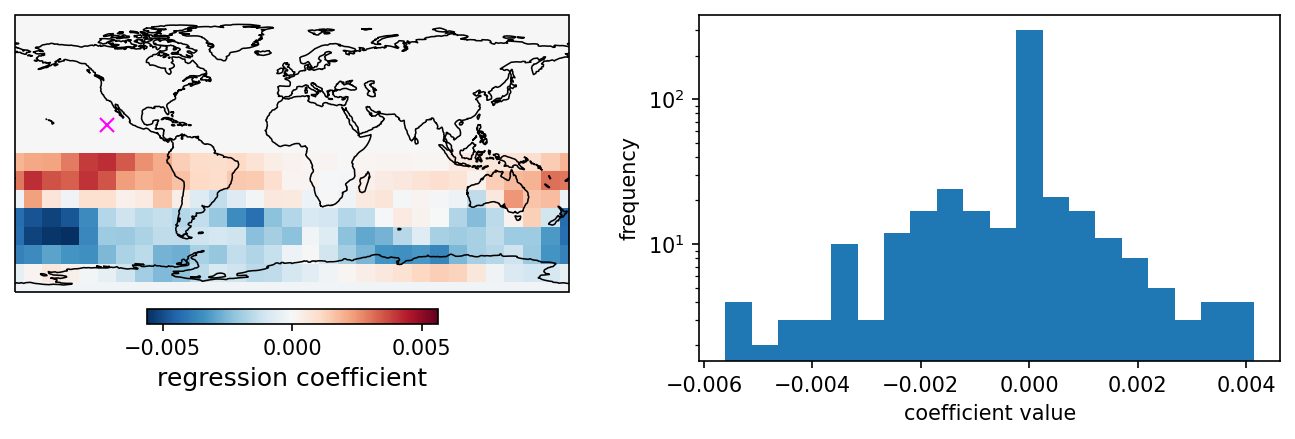

In [17]:
#--------------------------------------
# Regression Fitting
# reg = linear_model.LinearRegression()
# reg = linear_model.Lasso(alpha=200.)
reg = linear_model.Ridge(alpha=1e8)

reg.fit(x,y)
#--------------------------------------

# set unused coefficients to nan for plotting
data = np.reshape(reg.coef_,(len(da['latitude'].values),len(da['longitude'].values)))

# get rid of line at long = 0.0
data_cyc = np.append(data,data[:,0:1],axis=1)
lons_cyc = np.append(da['longitude'].values,360.)

# plot the figure of regression coefficients
data_crs = ct.crs.PlateCarree()
plt.figure(figsize=(11,3))
ax = plt.subplot(1,2,1,projection=ct.crs.PlateCarree())
ax.set_global()
ax.coastlines(linewidth = .75)

maxval = np.nanmax(np.abs(reg.coef_[:]))
image = ax.pcolor(lons_cyc, da['latitude'].values, data_cyc, transform=data_crs, cmap='RdBu_r', vmin=-maxval, vmax = maxval)
image.set_clim(-maxval,maxval)
cb = plt.colorbar(image, shrink=.5, orientation="horizontal", pad=.05)
cb.set_label('regression coefficient', fontsize=12)

plt.plot(da['longitude'].values[predictLonIndex],da['latitude'].values[predictLatIndex],'x',markersize=7, linewidth=10, color = 'fuchsia', transform=data_crs)

plt.subplot(1,2,2)
plt.hist(reg.coef_[:],20)
plt.yscale('log')
plt.xlabel('coefficient value')
plt.ylabel('frequency')
plt.show()

I love ridge regression since I do a lot of research with *maps*. $L_2$ regularization helps the weight get spread across predictors - thus often taking into account the correlations across predictors I know are there.